Ideas:
* Find method for determining the number of EOFs that are statistically significant, how many EOFs needed to reconstruct -- something to calculate this threshold, Chris Bretherton, Dennis??

# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from eofs.xarray import Eof 

In [2]:
import cftime
import scipy

In [3]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

import make_multisimulation_dataset

In [4]:
from load_ensembles import *
import quick_map

In [5]:
import make_multisimulation_dataset

# Load data

In [6]:
var='EFLX_LH_TOT'
domain='lnd'
ensemble='coupled'

In [7]:
end_spinup=40

## Load full ensemble data

In [8]:
if ensemble=='coupled':
    ensemble_coupled = load_coupled_ensemble(var=var, domain=domain, printon=False)
elif ensemble=='offline':
    ensemble_coupled = load_offline_ensemble(var=var, domain=domain, printon=False)

/glade/u/home/czarakas/coupled_PPE/code/utils/load_ensembles.py:46: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fpath)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [9]:
if ensemble=='offline':
    if domain=='atm':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/atm/proc/tseries/OFFL0000_PI_v02.cam.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    elif domain=='lnd':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/lnd/proc/tseries/OFFL0000_PI_v02.clm2.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
elif ensemble=='coupled':
    if domain=='atm':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    elif domain=='lnd':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/lnd/proc/tseries/COUP0000_PI_SOM.clm2.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
from load_gridcell_areas import *

### Function for calculating annual averages based on days per year

In [11]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
    return month_length

In [12]:
ds=basecase_lnd
month_length = xr.DataArray(get_dpm(ds.time.to_index(),
                                      calendar='noleap'),
                              coords=[ds.time], name='month_length')

numyears=np.size(ds.time.groupby('time.year').mean(dim='time').year)

In [13]:
# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()

# Test that the sum of the weights for each season is 1.0
#weights.groupby('time.month').sum().values
np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))

# Calculate the weighted average
ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')

In [14]:
def calculate_annual_timeseries(ds, var=var, season='Annual'):
    month_length = xr.DataArray(get_dpm(ds.time.to_index(),
                                      calendar='noleap'),
                              coords=[ds.time], name='month_length')
    
    numyears=np.size(ds.time.groupby('time.year').mean(dim='time'))
    
    if season=='Annual':
        weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each year is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
    
        # Calculate the weighted average
        ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')
        
        this_ensemble_tseries=ds_weighted[end_spinup:,:,:]
    else:
        months_filtered = month_length.where(month_length['time.season']==season)
        weights = months_filtered.groupby('time.year') / months_filtered.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each season is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
        
        ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')
        this_ensemble_tseries=ds_weighted[end_spinup:,:,:]
        
    return this_ensemble_tseries
    

# Check ensemble

In [15]:
ensemble_coupled[-1]=ensemble_coupled[-1].sel(time=slice('0049-01-16', '0188-12-16'))

In [16]:
expected_start_time=cftime.DatetimeNoLeap(49,1,16,12)
expected_end_time=cftime.DatetimeNoLeap(188,12,16,12)
for i,ds in enumerate(ensemble_coupled):
    print(ds.case_id)
    if np.size(ds.time)!=1680:
        print('!!!!! Time size is wrong dimension')
    if ds.time.values[0] != expected_start_time:
        print(ds.time.values[0])
    if ds.time.values[-1] != expected_end_time:
        print(ds.time.values[-1])
    print('----------')

COUP0001_PI_SOM_v02
----------
COUP0037_PI_SOM_v02
----------
COUP0007_PI_SOM_v02
----------
COUP0008_PI_SOM_v02
----------
COUP0009_PI_SOM_v02
----------
COUP0010_PI_SOM_v02
----------
COUP0013_PI_SOM_v02
----------
COUP0014_PI_SOM_v02
----------
COUP0015_PI_SOM_v02
----------
COUP0016_PI_SOM_v02
----------
COUP0017_PI_SOM_v02
----------
COUP0018_PI_SOM_v02
----------
COUP0019_PI_SOM_v02
----------
COUP0020_PI_SOM_v02
----------
COUP0021_PI_SOM_v02
----------
COUP0022_PI_SOM_v02
----------
COUP0023_PI_SOM_v02
----------
COUP0024_PI_SOM_v02
----------
COUP0025_PI_SOM_v02
----------
COUP0026_PI_SOM_v02
----------
COUP0027_PI_SOM_v02
----------
COUP0028_PI_SOM_v02
----------
COUP0029_PI_SOM_v02
----------
COUP0030_PI_SOM_v02
----------
COUP0031_PI_SOM_v02
----------
COUP0032_PI_SOM_v02
----------
COUP0033_PI_SOM_v02
----------
COUP0034_PI_SOM_v02
----------
COUP0035_PI_SOM_v02
----------
COUP0036_PI_SOM_v02
----------
COUP0003_PI_SOM_v02
----------
COUP0004_PI_SOM_v02
----------
COUP0005

# Calculate annual means

In [17]:
num_ensemble=np.shape(ensemble_coupled)[0]
num_seasons=4

# Calculate seasonal cycle of reference simulation
seasonal_cycle_ref=[]
for j,season in enumerate(['DJF','MAM','JJA','SON']):
    ref_tseries=calculate_annual_timeseries(basecase_lnd,season=season).mean(dim='year')
    seasonal_cycle_ref.append((ref_tseries*landweights).mean(dim=['lat','lon']))

# Calculate seasonal cycle of ensemble members
seasonal_cycle=np.zeros([num_ensemble, num_seasons])
seasonal_cycle[:]=np.nan
for i,ds in enumerate(ensemble_coupled):
    print(i)
    for j,season in enumerate(['DJF','MAM','JJA','SON']):
        seasonal_avg=(calculate_annual_timeseries(ds, var=var, season=season).mean(dim='year')*
                      landweights).mean(dim=['lat','lon'])
        seasonal_cycle[i,j]=seasonal_avg.load()

seasonal_cycle_diff=seasonal_cycle-np.array(seasonal_cycle_ref)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [18]:
seasonal_cycle_diff=seasonal_cycle-np.array(seasonal_cycle_ref)

In [19]:
# Calculate seasonal cycle of reference simulation
season='Annual'
ref_annual=calculate_annual_timeseries(basecase_lnd,season=season).mean(dim='year')
ref_annual_global=((ref_annual*landweights).mean(dim=['lat','lon']))

# Calculate seasonal cycle of ensemble members
annual_avgs=[]
for i,ds in enumerate(ensemble_coupled):
    print(i)
    annual_avg=(calculate_annual_timeseries(ds, var=var, season=season).mean(dim='year')*
                      landweights).mean(dim=['lat','lon'])
    annual_avgs.append(annual_avg.load())
    
annual_diffs=np.array(annual_avgs)-ref_annual_global.values

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


skipped
-0.12884573640150165
-----
skipped
0.10398012681279312
-----
skipped
0.09834913126911715
-----
skipped
-0.13676867864099052
-----
skipped
0.0850631151212653
-----
skipped
0.017760305853073532
-----


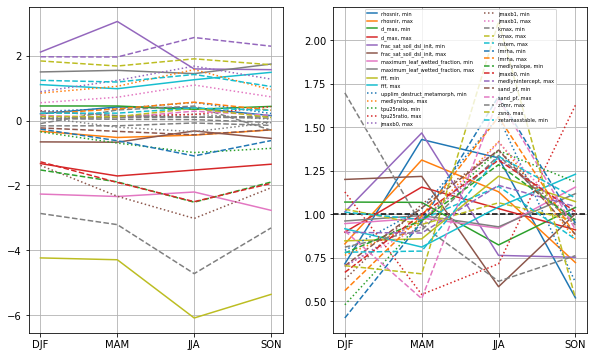

In [20]:
threshold_seasonal_cycle=0.15
x=[0,1,2,3]
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
for i,ds in enumerate(ensemble_coupled):
    if i>18:
        linestyle='--'
    elif i>9:
        linestyle=':'
    else:
        linestyle='-'
    if np.abs(annual_diffs[i])>threshold_seasonal_cycle:
        plt.plot(x,seasonal_cycle_diff[i,:],linestyle)
    else:
        plt.plot(x,seasonal_cycle_diff[i,:],linestyle,color='gray')
my_xticks = ['DJF','MAM','JJA','SON']
plt.xticks(x, my_xticks)
plt.grid()

plt.subplot(1,2,2)
plt.axhline(y=1,linestyle='--',color='k')
for i,ds in enumerate(ensemble_coupled):
    if i>18:
        linestyle='--'
    elif i>9:
        linestyle=':'
    else:
        linestyle='-'
    if np.abs(annual_diffs[i])>threshold_seasonal_cycle:
        plt.plot(x,seasonal_cycle_diff[i,:]/annual_diffs[i],linestyle,
                 label=crosswalk.description.values[i])#label=np.round(annual_diffs[i],2))
    else:
        print('skipped')
        print(annual_diffs[i])
        print('-----')
        #plt.plot(x,seasonal_cycle_diff[i,:]/annual_diffs[i],linestyle,color='gray',
        #         label=crosswalk.description.values[i])
        
my_xticks = ['DJF','MAM','JJA','SON']
plt.legend(ncol=2,fontsize=5)
plt.xticks(x, my_xticks)
plt.grid()

In [21]:
max_season=[]
for i,ds in enumerate(ensemble_coupled):
    max_season.append(np.argmax(np.abs(seasonal_cycle_diff[i,:])))

In [22]:
unique, counts = np.unique(np.array(max_season), return_counts=True)

In [23]:
counts*100/np.sum(counts)

array([11.11111111, 13.88888889, 63.88888889, 11.11111111])

In [24]:
DJF:
    'd_max, min', 'frac_sat_soil_dsl_init, max', 'z0mr, min',
       'z0mr, max', 'zsno, min'
MAM:
    'rhosnir, max', 'frac_sat_soil_dsl_init, min',
       'upplim_destruct_metamorph, max', 'nstem, min', 'lmrha, max',
       'zetamaxstable, min'
JJA:'d_max, max', 'maximum_leaf_wetted_fraction, max', 'fff, min',
       'fff, max', 'medlynslope, max', 'tpu25ratio, min', 'jmaxb0, max',
       'jmaxb1, min', 'jmaxb1, max', 'kmax, min', 'kmax, max',
       'nstem, max', 'lmrha, min', 'medlynslope, min', 'jmaxb0, min',
       'medlynintercept, max', 'sand_pf, min', 'sand_pf, max',
       'zsno, max', 'zetamaxstable, max'
    
SON:'rhosnir, min', 'maximum_leaf_wetted_fraction, min',
       'upplim_destruct_metamorph, min', 'medlynintercept, min',
       'tpu25ratio, max'

SyntaxError: invalid syntax (<ipython-input-24-4c4f7f628fb3>, line 1)

In [25]:
crosswalk.description.values[np.array(max_season)==3]

array(['maximum_leaf_wetted_fraction, min',
       'maximum_leaf_wetted_fraction, max', 'fff, max', 'tpu25ratio, max'],
      dtype=object)

# T Test significance of changes

In [26]:
season='Annual'#'Annual','DJF,'MAM','JJA','SON'

In [27]:
ds_grid = ensemble_coupled[0]

var_array_ttest = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)
var_array_pval = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Calculate where changes are significant

In [28]:
ref_tseries=calculate_annual_timeseries(basecase_lnd,season=season)
for i, ds in enumerate(ensemble_coupled):
    ds_annual=calculate_annual_timeseries(ds, var=var, season=season)
    [tstat, pval] = scipy.stats.ttest_ind(ref_tseries, ds_annual, equal_var=False)#, alternative='two-sided')
    diff=ds_annual.mean(dim='year')-ref_tseries.mean(dim='year')
    var_array_ttest[:,:,i]=tstat
    var_array_pval[:,:,i]=pval

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/E

### Print fraction of land surface where changes are significant

In [29]:
for i, ds in enumerate(ensemble_coupled):
    print(ds.case_id)
    print(crosswalk.description.values[(crosswalk.key_coupledPPE==ds.case_id[0:8]).values][0])
    pval=var_array_pval[:,:,i]
    sig_mask=(pval<=0.05)
    frac_changed=(sig_mask*landweights).mean(dim=['lat','lon'])
    print(frac_changed.values)
    print('-----------')

COUP0001_PI_SOM_v02
rhosnir, min
0.3685834
-----------
COUP0037_PI_SOM_v02
rhosnir, max
0.34721026
-----------
COUP0007_PI_SOM_v02
d_max, min
0.33940968
-----------
COUP0008_PI_SOM_v02
d_max, max
0.63005966
-----------
COUP0009_PI_SOM_v02
frac_sat_soil_dsl_init, min
0.656987
-----------
COUP0010_PI_SOM_v02
frac_sat_soil_dsl_init, max
0.4068326
-----------
COUP0013_PI_SOM_v02
maximum_leaf_wetted_fraction, min
0.60772145
-----------
COUP0014_PI_SOM_v02
maximum_leaf_wetted_fraction, max
0.58007526
-----------
COUP0015_PI_SOM_v02
fff, min
0.84162575
-----------
COUP0016_PI_SOM_v02
fff, max
0.47548255
-----------
COUP0017_PI_SOM_v02
upplim_destruct_metamorph, min
0.22532618
-----------
COUP0018_PI_SOM_v02
upplim_destruct_metamorph, max
0.27501896
-----------
COUP0019_PI_SOM_v02
medlynslope, max
0.545556
-----------
COUP0020_PI_SOM_v02
medlynintercept, min
0.11243937
-----------
COUP0021_PI_SOM_v02
tpu25ratio, min
0.40590054
-----------
COUP0022_PI_SOM_v02
tpu25ratio, max
0.17924243
--------

### Calculate mean differences
Make a data array that stacks all the differences from the reference 
(i.e. dimension are [lat, lon, num_ensemble_simulations]

In [30]:
ds_grid = ensemble_coupled[0]
var_array = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [31]:
ref_tseries=calculate_annual_timeseries(basecase_lnd,season=season)
for i,ds in enumerate(ensemble_coupled):
    print(i)
    ds_annual=calculate_annual_timeseries(ds, season=season)
    
    diff = ds_annual.mean(dim='year')-ref_tseries.mean(dim='year')
    
    var_array[:,:,i]=diff

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [32]:
descriptions = []
for key in var_array.ensemble_key.values:
    if np.nansum(crosswalk.Key_short==key)>0:
        descriptions.append(crosswalk.description[crosswalk.Key_short==key].values[0])
    else:
        print('Error')
     #   descriptions.append('0000')
    #print(key)#ensemble_coupled=load_coupled_ensemble(var=var)

In [93]:
landweights*

<xarray.DataArray ()>
array(0.99999994, dtype=float32)

In [74]:
landweights_lats=landarea/landarea.sum(dim='lon')

In [33]:
unitconv=86400/(2260*997)

In [85]:
var_array_land=(var_array)#.where(landfrac>0.9)

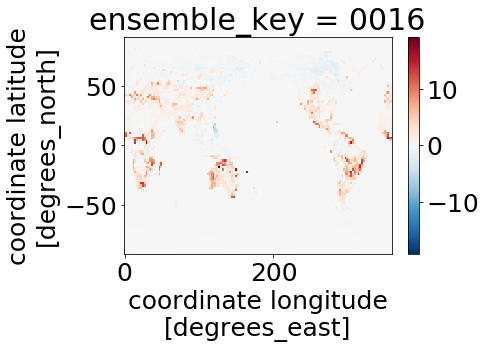

In [90]:
var_array[:,:,9].plot()

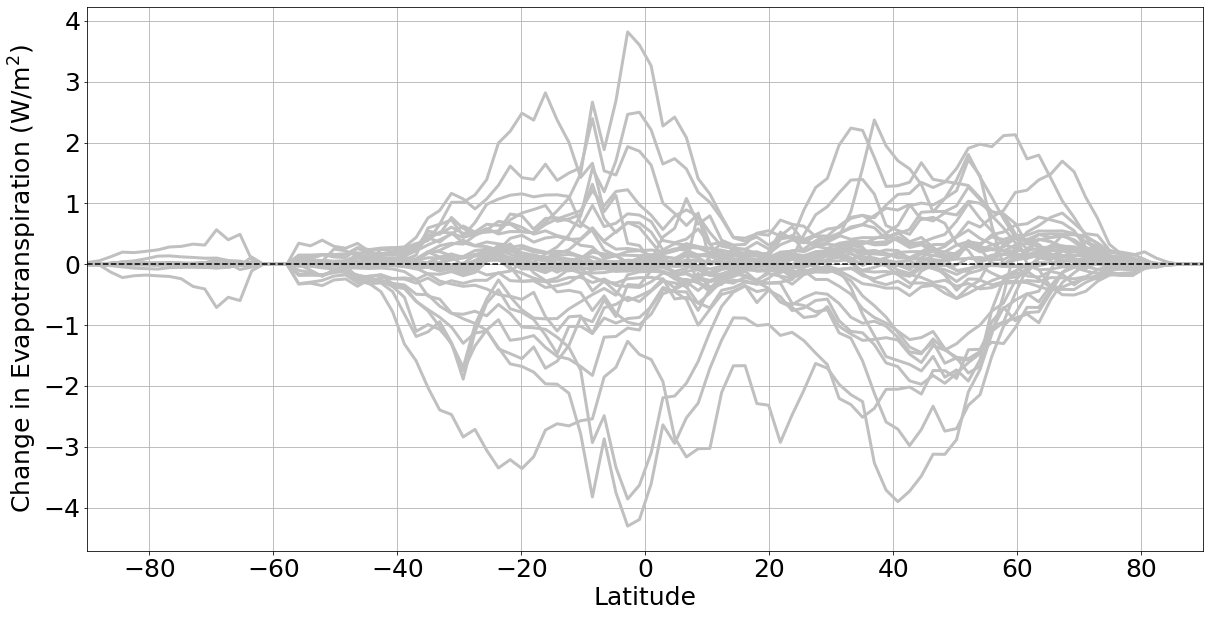

In [86]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 25})

for i in np.arange(0, 36):
    plt.plot(var_array.lat, var_array_land[:,:,i].mean(dim='lon'),'-',linewidth=3, color='silver', alpha=1)
plt.grid()
plt.xlim([-90,90])
plt.axhline(y=0,linestyle='--',color='k')
plt.xlabel('Latitude')
plt.ylabel('Change in Evapotranspiration (W/m$^2$)')
plt.savefig('Change_in_ET_CoupledPPE.png')

### Get area weights

#### Calculate area weights

In [36]:
import load_gridcell_areas

In [37]:
# area dataArray
ds_to_analyze=var_array[:,:,0]
da_area = area_grid(ds_to_analyze.lat, ds_to_analyze.lon)
# total area
total_area = da_area.sum(['lat','lon'])
#  weighted by grid-cell area
areaweights = (da_area) / total_area

In [38]:
if domain=='atm':
    landweights=landweights.reindex_like(areaweights, tolerance=0.05, method='nearest')

# EOF analysis of changes in mean temperature

### Set up data

In [125]:
var_array=var_array#[:,:,0:34]

In [126]:
deltaT=(var_array-var_array.mean(dim='ensemble_key'))
deltaT_global=(deltaT*landweights).mean(dim=['lat','lon'])
deltaT_normalized=deltaT#-deltaT_global

In [127]:
def quick_map_subplot_contour(mapdata_for_subplot, lat, lon, nrow=3, ncol=3, ind=1, title=None,
              cmap=None, clim=None, sigmask=None,plot_cbar=False):
    """ Creates map """
    ax = plt.subplot(nrow, ncol, ind+1, projection=ccrs.Robinson())
    ax.coastlines(resolution='110m') #learn how to add resolution here??
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata_for_subplot, coord=lon)

    cs = plt.contourf(cyclic_lons, lat, cyclic_data,
                            transform=ccrs.PlateCarree(), extend='both',levels=np.linspace(clim[0],clim[1],10),
                     add_colorbar=False)

    if sigmask is not None:
        cyclic_data_mask, cyclic_lons_mask = add_cyclic_point(sigmask, coord=lon)
        ax.contourf(
            cyclic_lons_mask, lat, cyclic_data_mask,
            transform=ccrs.PlateCarree(),
            colors='none',
            levels=[0.5, 1.5],
            hatches=['///////'])
        
    # Choose your colormap
    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)

    ax.patch.set_alpha(1.0)
    
    if title is not None: plt.title(title, fontsize=8)

    if clim:
        plt.clim(clim)
        cs.set_clim(clim[0], clim[1])
        cs.set_clim(clim)
    
    if plot_cbar:
        cbar = plt.colorbar(ax=ax, orientation='horizontal',
                                extend='both', pad=.02, shrink=0.9)
        cbar.ax.tick_params(labelsize=14)

        if clim:
            cbar.set_clim(clim)

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


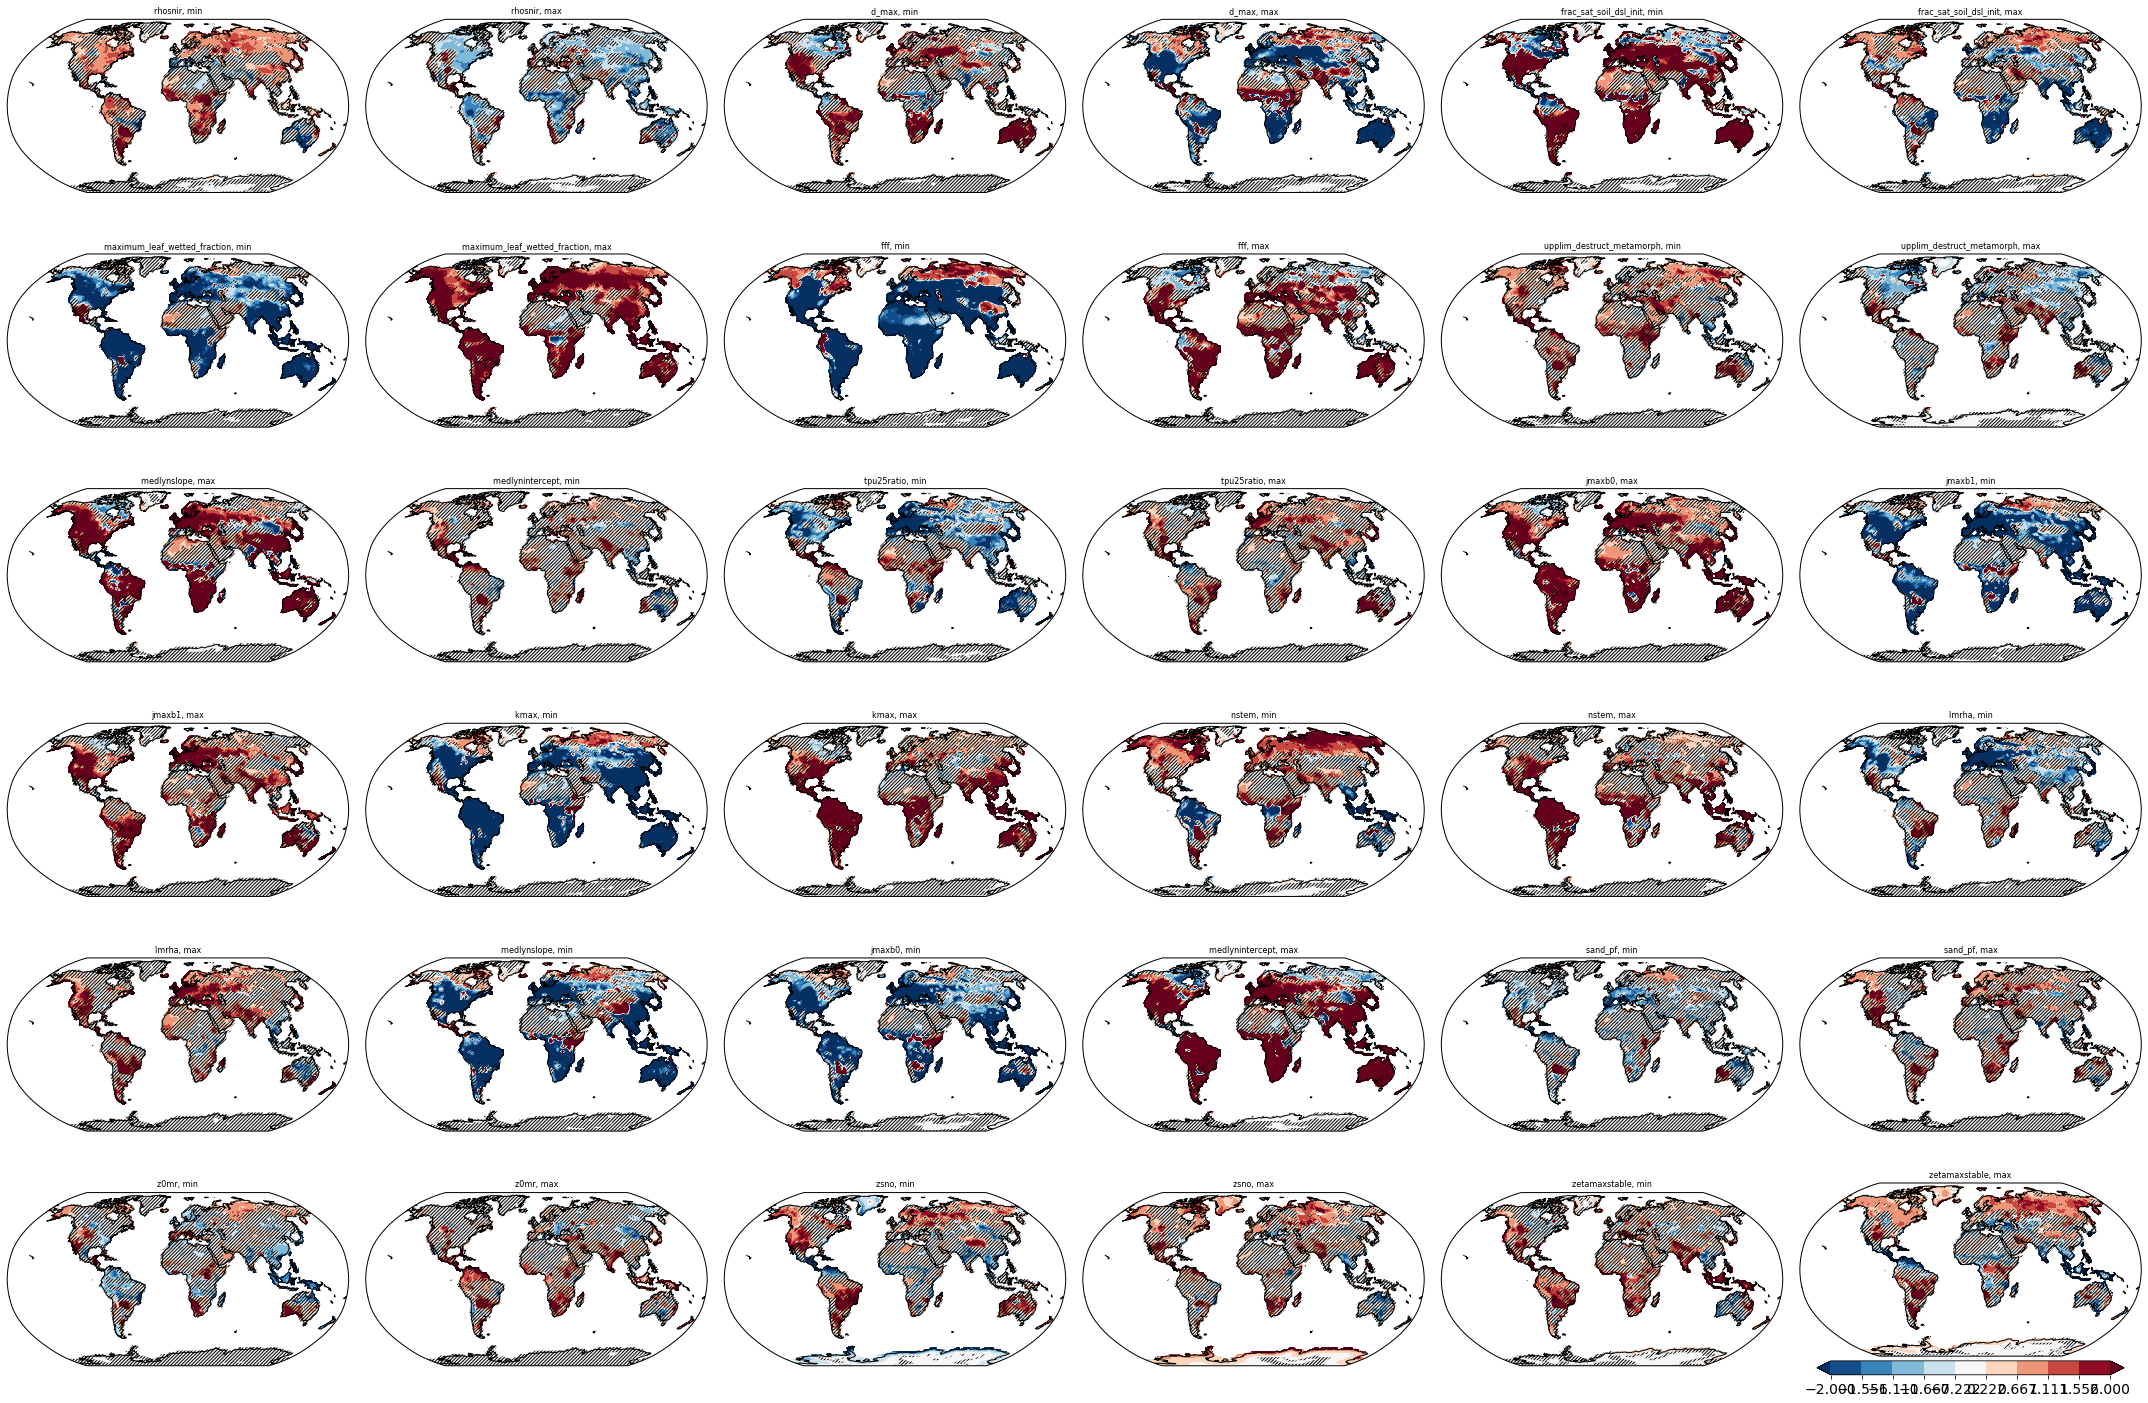

In [128]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(30,20))
for i in np.arange(0,36):
    plt.subplot(6,6,i+1)
    mapdata_for_subplot=var_array[:,:,i].where(landweights>0)
    sigmask=var_array_pval[:,:,i]>0.05

    if i<35:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=i,
                               cmap=plt.cm.RdBu_r, clim=[-2,2],title=crosswalk.description.values[i],
                     sigmask=sigmask)
    else:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=i,
                               cmap=plt.cm.RdBu_r, clim=[-2,2],title=crosswalk.description.values[i],
                     sigmask=sigmask, plot_cbar=True)
    
plt.tight_layout()
plt.savefig('Global_'+var+'_maps_'+ensemble+'_'+season+'.png')

In [129]:
"""
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,15))
for i in np.arange(0,36):
    plt.subplot(6,6,i+1)
    var_array[:,:,i].where(landweights>0).plot()
plt.tight_layout()
plt.savefig('Global_'+var+'_maps_'+ensemble+'.png')
"""

"\nplt.rcParams.update({'font.size': 12})\nplt.figure(figsize=(15,15))\nfor i in np.arange(0,36):\n    plt.subplot(6,6,i+1)\n    var_array[:,:,i].where(landweights>0).plot()\nplt.tight_layout()\nplt.savefig('Global_'+var+'_maps_'+ensemble+'.png')\n"

### Do EOF

In [130]:
ds_eofs = deltaT_normalized#[:,:,0:34]
ds_eofs=ds_eofs#*86400*365*1000

In [131]:
from datetime import datetime, timedelta
num_ensembles=np.shape(ds_eofs)[2]
print(num_ensembles)
date2=datetime(2000,1,1)+timedelta(days=num_ensembles, minutes=0)
date2_str=date2.isoformat()[0:10]

36


In [132]:
# Rearrange all-model dataset for EOF
ds_eofs=ds_eofs.transpose()
ds_eofs=ds_eofs.rename({"ensemble_key": "time"})
ds_eofs['time']=np.arange('2000-01-01', date2_str, dtype='datetime64') #11
ds_eofs=ds_eofs-ds_eofs.mean(dim='time')

In [133]:
#solver = Eof(ds_eofs, weights=areaweights.transpose())
solver = Eof(ds_eofs, weights=landweights.transpose())
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()#pcscaling=2)

#### Check reconstruction

In [134]:
reconstructed=solver.reconstructedField(1)
reconstructed_mode0=eofs[:,:,0]*pcs[:,0]/landweights

In [135]:
diff=reconstructed_mode0[:,:,1]-reconstructed[1,:,:]

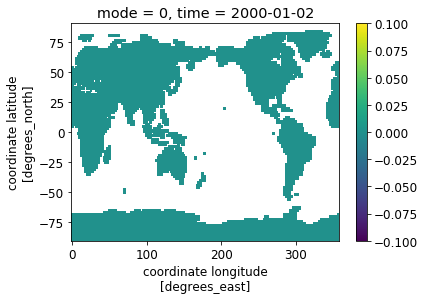

In [136]:
diff.plot()

## Make figures

##### Map of range

In [137]:
import matplotlib as mpl
# force the first color entry to be grey
cmaplist=['#4A50A4','#5B7DB7','#A9D9E4', '#7FC883','#57B041',
          '#AACF46','#EFE151','#F1CF45','#E6A53C','#D3582A',
          '#C83E2C','#A02C40','#591A8E']


# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 14)

In [138]:
datarange=(var_array.quantile(0.95, dim='ensemble_key')-
           var_array.quantile(0.05, dim='ensemble_key'))

In [139]:
mapdata=datarange

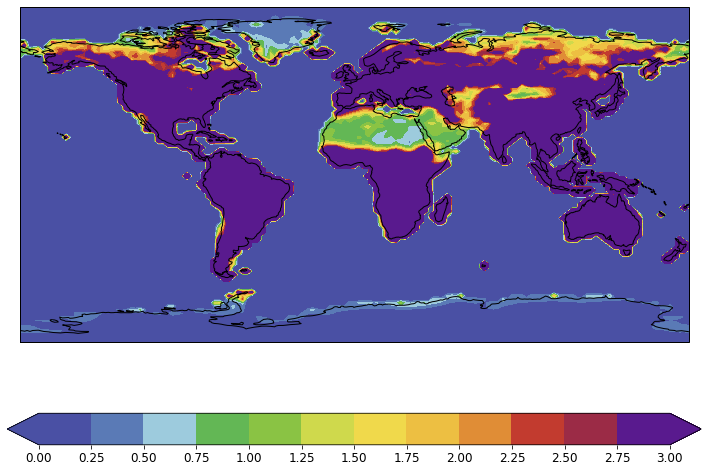

In [140]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.contourf(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=cmap, levels=np.arange(0, 3.25, 0.25), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree(), extend='both')
plt.colorbar(extend='both', orientation='horizontal', ticks=np.arange(0, 3.25, 0.25))
plt.tight_layout()
plt.savefig('EOF2_TSKIN_'+ensemble+'.png')

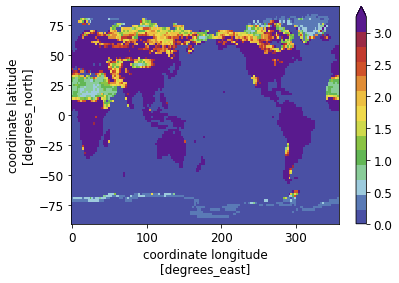

In [141]:
datarange.plot(cmap=cmap, vmin=0, vmax=3.25)

#### Fraction of variance explained

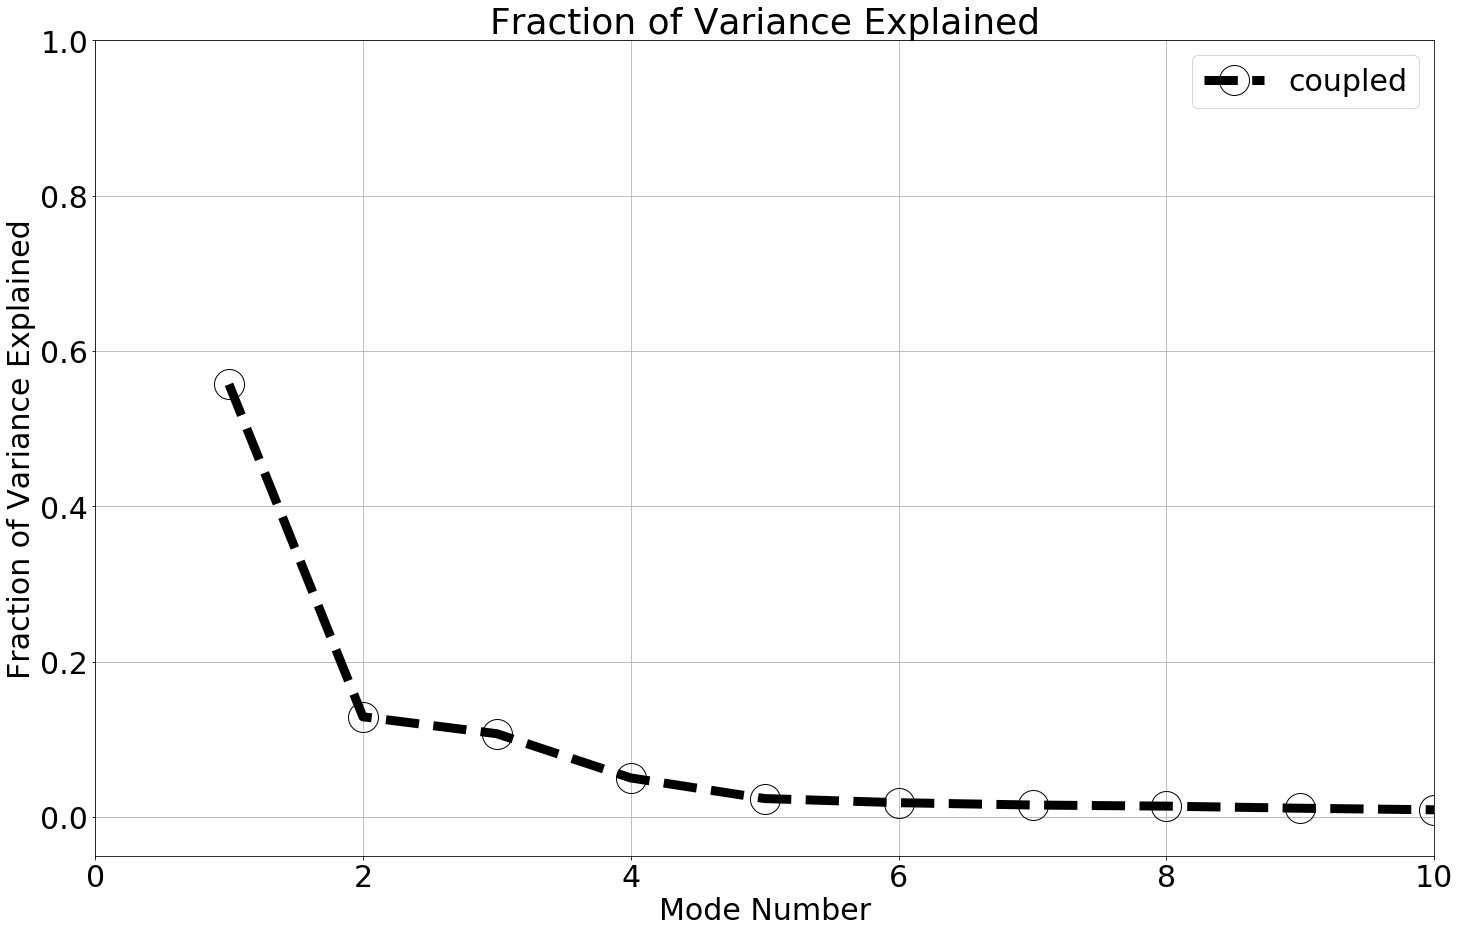

In [142]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(24,15))
plt.plot(np.arange(1,np.size(ds_eofs['time'])+1),solver.varianceFraction().values,
         'o--k', fillstyle='none',markersize=30,linewidth=9, label=ensemble)
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([0,10])
plt.ylim([-0.05,1])
plt.title('Fraction of Variance Explained')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Variance Explained')
plt.grid()
plt.legend()
plt.savefig(var+'_frac_variance_explained.png')

In [143]:
for i in np.arange(0,4):
    print('EOF '+str(i+1))
    print(solver.varianceFraction().values[i])
#print(solver.varianceFraction().values[0:2])

EOF 1
0.5570764911676976
EOF 2
0.1290380333794914
EOF 3
0.10723219743405168
EOF 4
0.05025881524178053


In [144]:
warming_factorPC0_1degreeglobal=1/(eofs[:,:,0]).mean(dim=['lat','lon'])
warming_factorPC1_1degreeglobal=1/(eofs[:,:,1]).mean(dim=['lat','lon'])
warming_factorPC2_1degreeglobal=1/(eofs[:,:,2]).mean(dim=['lat','lon'])
warming_factorPC3_1degreeglobal=1/(eofs[:,:,3]).mean(dim=['lat','lon'])

/glade/u/home/czarakas/coupled_PPE/code/utils/quick_map.py:82: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(clim)


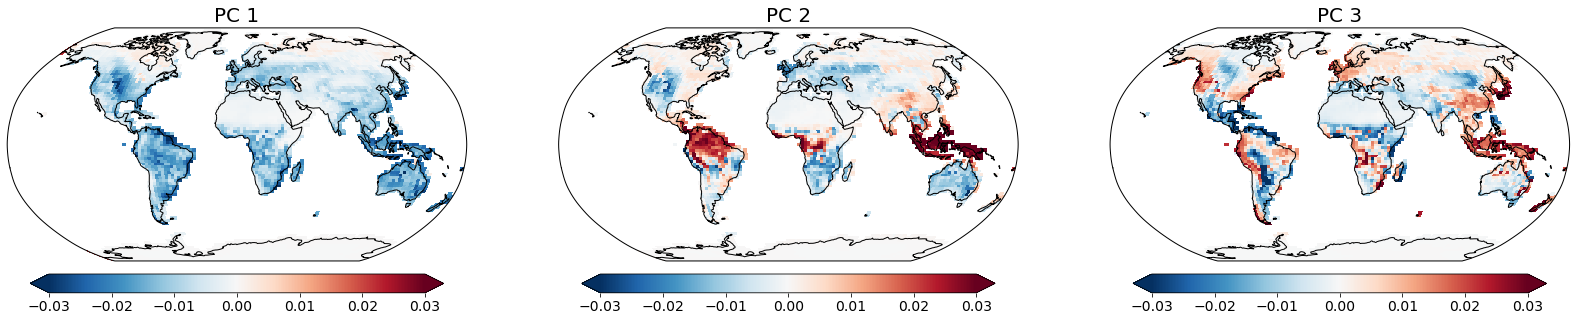

In [145]:
lats = eofs['lat'].values
lons = eofs['lon'].values
fig = plt.figure(figsize=(28, 12))
for i in range(0,3):
    quick_map.quick_map_subplot(((eofs[:,:,i])/landweights).values,lats,lons, nrow=1, ncol=3, ind=i,
                                clim=[-0.03,0.03], cmap=plt.cm.RdBu_r,
                                title='PC '+str(i+1))
plt.savefig(var+'_PCs.png')

In [146]:
mapdata=eofs[:,:,0]*warming_factorPC0_1degreeglobal/landweights
print((mapdata*landweights).mean(dim=['lat','lon']))

<xarray.DataArray ()>
array(1.)
Coordinates:
    mode     int64 0


In [ ]:
import cartopy
plt.rcParams.update({'font.size': 25})
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("BrBG",11), vmin=-4, vmax=4,#levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree())#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')#, ticks=np.arange(-0.025, 0.030, 0.005))
plt.tight_layout()
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN, facecolor='white')
plt.savefig('EOF2_TSKIN_'+ensemble+'.png')

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("RdBu_r",10),vmin=-0.025, vmax=0.025,# levels=np.arange(-2.0,2.1,0.4), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree())#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')#, ticks=np.arange(-2.0,2.1,0.4))
plt.tight_layout()
plt.savefig('EOF2_TSKIN_'+ensemble+'.png')

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(mapdata_coupled.lat, mapdata_coupled.mean(dim='lon'),color='black',linewidth=4)
#plt.plot(mapdata.lat, mapdata.mean(dim='lon'),color='black',linestyle='--',linewidth=2)
plt.plot(mapdata2.lat, mapdata2.mean(dim='lon'),color='firebrick',linewidth=4)
plt.ylim([-0.01, 2.2])
plt.savefig('ZonalMean_Comparison.png')
plt.grid()

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, clim=[-2, 2], vmin=-2, vmax=2,
                   cmap=plt.cm.get_cmap("RdBu_r"), #levels=np.arange(-2.6,2.7,0.4), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree(), )#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')
plt.tight_layout()
plt.savefig('EOF2_CLDTOT.png')

# In EOF space 

In [ ]:
plt.rcParams.update({'font.size': 14})

In [ ]:
labels=descriptions#var_array.ensemble_key.values
fig = plt.figure(figsize=(9, 4))
plt.plot([0.5,np.size(labels)-0.5],[0,0],'-k')
for i in range(0,3):
    pcs_annual = np.abs(pcs[:,i])
    plt.plot(np.arange(1,np.size(pcs_annual['time'])+1),
             pcs_annual,label='Mode '+str(i+1),linewidth=1,marker='.',markersize=15)
    plt.xlabel('Model Name')
    plt.ylabel('Principal Component')
    plt.title('Strength of Principal Mode for each Model')
plt.legend()
#plt.xlim([0.5,np.size(labels)-0.5])
plt.xticks(np.arange(1,np.size(labels)+0.5,1),labels=labels, rotation=90)
plt.grid()
plt.savefig(var+'_strength_principal_mode_per_sim.png')

In [ ]:
markerstyles=['o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'o',
             'o',
             'o',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v']

In [ ]:
fillstyles=['none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'full',
             'none',
             'none',
             'full',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
            'none',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
           'none']

In [ ]:
colors=['tab:blue',
             'tab:blue',
             'tab:orange',
             'tab:orange',
             'tab:green',
             'tab:green',
             'tab:red',
             'tab:red',
             'tab:purple',
             'tab:purple',
             'tab:brown',
             'tab:brown',
             'tab:pink', #WRONG
             'tab:olive', #WRONG
             'tab:cyan',
              'tab:cyan',
        'tab:gray',
            'tab:blue',
             'tab:blue',
             'tab:orange',
             'tab:orange',
             'tab:green',
             'tab:green',
             'tab:red',
             'tab:red',
             'tab:pink',
             'tab:gray',
             'tab:olive',
             'tab:pink',
             'tab:pink',
             'tab:cyan',
              'tab:cyan',
       'tab:gray',
       'tab:gray',
       'tab:olive',
        'tab:olive']

# Compare leading PC with global mean warming

In [ ]:
global_mean_deltaT=[]
for m, modelname in enumerate(labels):
    deltaT_global=(deltaT_normalized[:,:,m]*landweights).mean(dim=['lat','lon']).values
    global_mean_deltaT.append(deltaT_global)

In [ ]:
plt.plot(np.array(global_mean_deltaT),
         pcs[:,0].values/warming_factorPC0_1degreeglobal.values,'o')
plt.grid()
plt.xlabel('Global Mean Change in Land ET')
plt.ylabel('PC1')
plt.plot([-5,3],[-5,3],'-k')

In [ ]:
fig = plt.figure(figsize=(9, 10))
#plt.plot([-500,170],[0,0],'-k')
#plt.plot([0,0],[-175,150],'-k')
pc1 = (pcs[:,0].values)
pc2 = (pcs[:,1].values)
for m, modelname in enumerate(labels):
    if m%2==0:
        fillstyle='none'
    else:
        fillstyle='full'
    plt.plot(-pc1[m], pc2[m],markerstyles[m],color=colors[m],fillstyle=fillstyles[m],
             linewidth=0,markersize=15, label=modelname)
    #plt.plot(-pc1[m], pc2[m],markerstyles[m],'.,fillstyle=fillstyles[m],
    #         linewidth=0,markersize=15, label=modelname)
    #plt.annotate(modelname, [-pc1[m]+0.0002, pc2[m]-0.0001])
plt.xlabel('Mode 1')
plt.ylabel('Mode 2')
plt.title('Models in PC Space')
#plt.legend(fontsize=8, ncol=3)
#plt.xlim([-0.009,0.007])
#plt.ylim([-0.009,0.007])
#plt.ylim([-20,70])
plt.grid()
plt.savefig(var+'_PC1vsPC2_projection.png')

In [ ]:
fig = plt.figure(figsize=(9, 6))
#plt.plot([-500,170],[0,0],'-k')
#plt.plot([0,0],[-175,150],'-k')
pc1 = pcs[:,0].values
pc2 = pcs[:,1].values
for m, modelname in enumerate(labels):
    if modelname=='CESM2':
        plt.plot(pc1[m], pc2[m],'.k',linewidth=0,markersize=15, label=modelname)
    else:
        plt.plot(pc1[m]/warming_factorPC0_1degreeglobal, 
                 pc2[m]/warming_factorPC1_1degreeglobal,
                 marker='o',fillstyle='none',color='gray',linewidth=0,markersize=15, label=modelname)

    if np.abs(pc1[m]/warming_factorPC0_1degreeglobal)>40:#0.75:
        plt.annotate(modelname, [pc1[m]/warming_factorPC0_1degreeglobal, 
                 pc2[m]/warming_factorPC1_1degreeglobal,])
    if np.abs(pc2[m]/warming_factorPC1_1degreeglobal)>0.1:#0.005:
        plt.annotate(modelname, [pc1[m]/warming_factorPC0_1degreeglobal, 
                pc2[m]/warming_factorPC1_1degreeglobal,])

plt.xlabel('Mode 1')
plt.ylabel('Mode 2')
plt.title('Models in PC Space')
#plt.legend(fontsize=12)
#plt.xlim([-110,150])
plt.axhline(y=0,linestyle='--',color='gray')
plt.axvline(x=0,linestyle='--',color='gray')
#plt.ylim([-0.1,0.1])
plt.savefig(var+'_PC1vsPC2_projection.png')

# Bar chart

In [96]:
global_land_changes=(var_array*landweights).mean(dim=['lat','lon'])

In [97]:
crosswalk['Land_delta']=np.nan

for i, desc in enumerate(var_array.ensemble_key.values):
    crosswalk['Land_delta'][i+1]=global_land_changes[i]

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [107]:
params=['fff','frac_sat_soil_dsl_init','d_max', 'sand_pf',
        'upplim_destruct_metamorph', 'z0mr', 'zetamaxstable', 'zsno',
        'kmax','medlynslope','medlynintercept',
        'jmaxb0', 'jmaxb1', 'tpu25ratio',
        'rhosnir',
        'lmrha',
        'maximum_leaf_wetted_fraction','nstem']
param_colors=['blue','blue', 'blue','blue',
        'purple', 'purple', 'purple', 'purple',
        'forestgreen', 'forestgreen', 'forestgreen',
        'lightseagreen', 'lightseagreen','lightseagreen',
              'goldenrod',
              'lightgreen',
        'orange','orange']

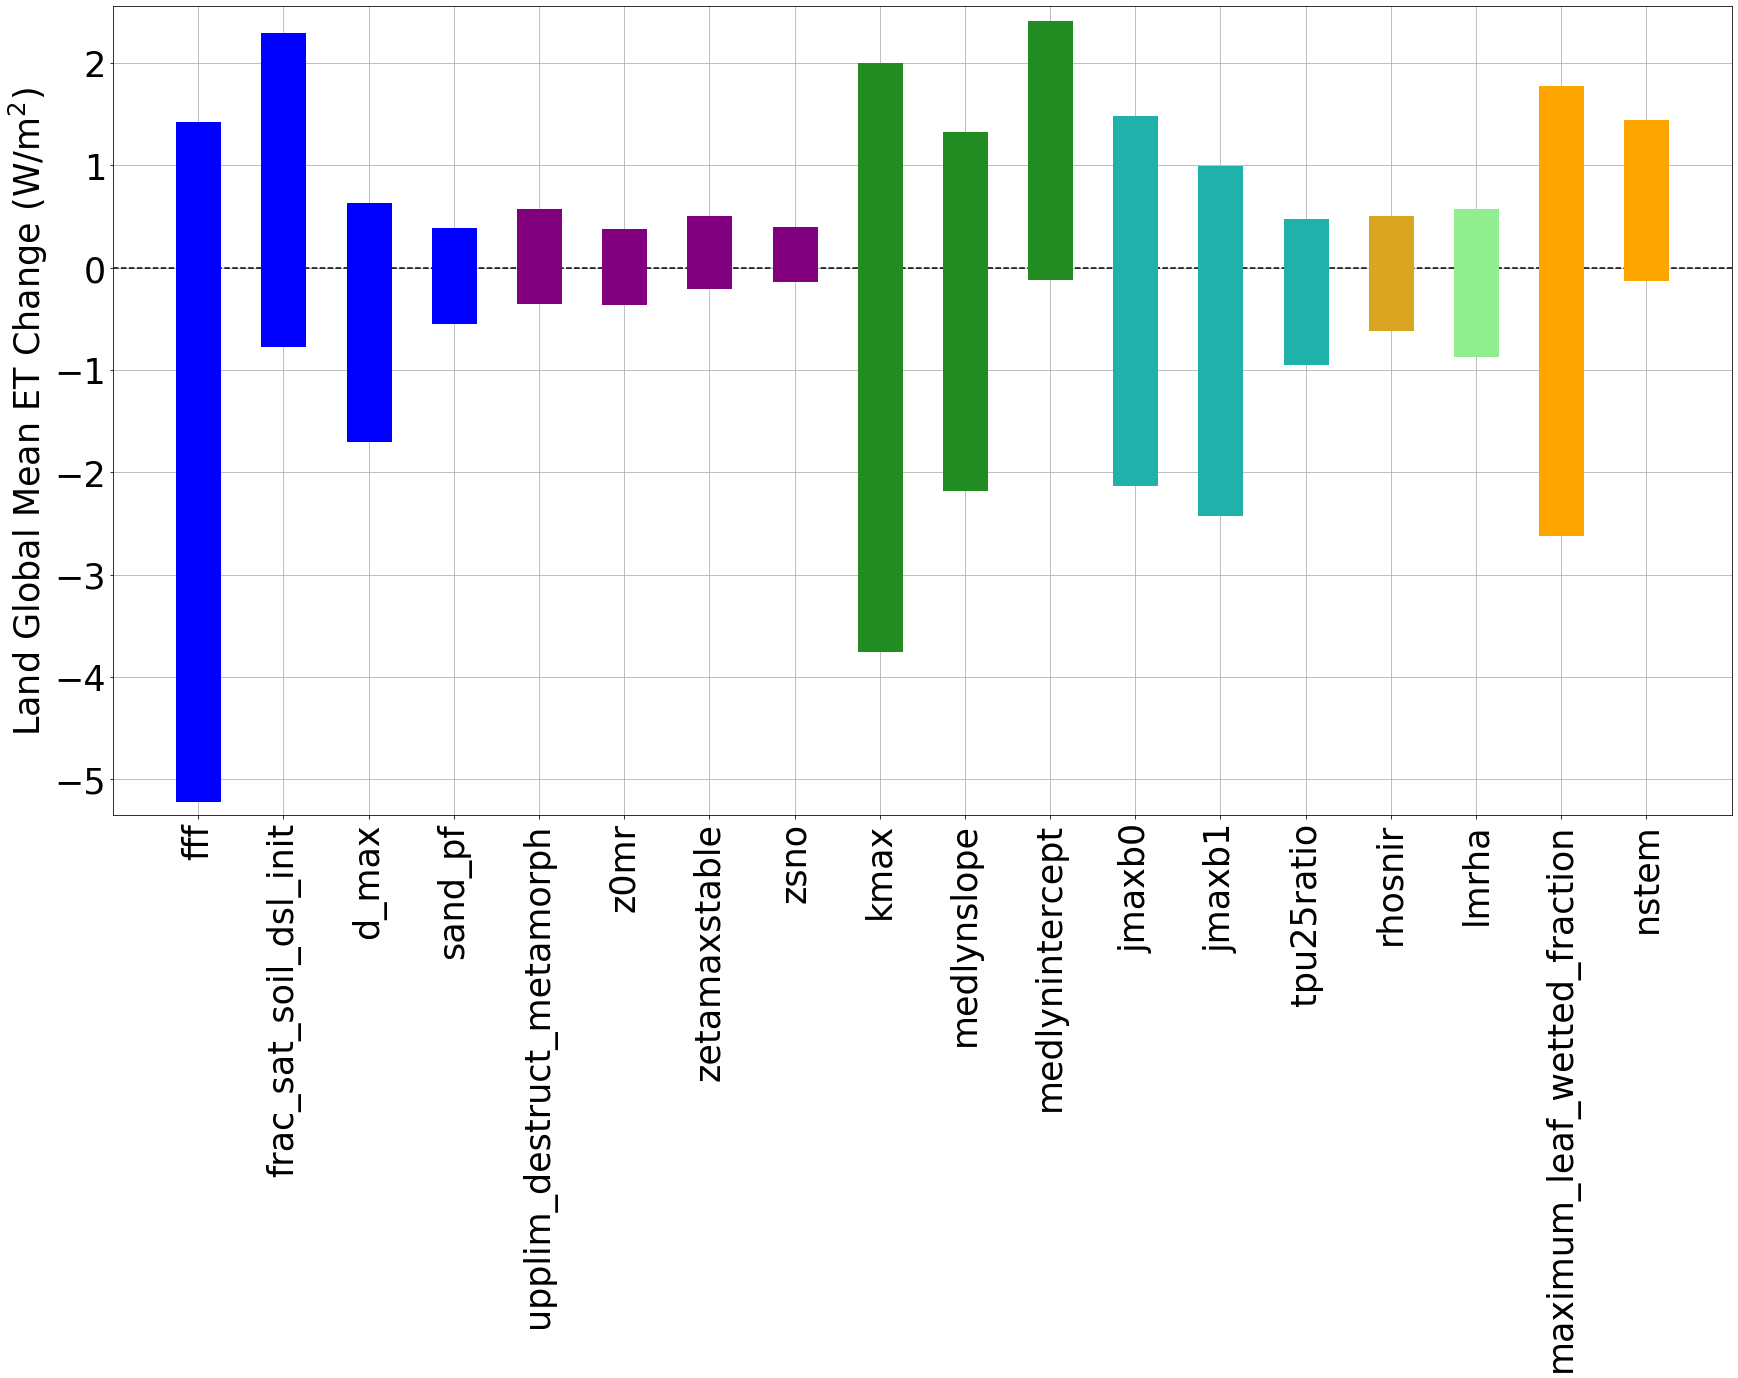

In [124]:
plt.figure(figsize=(25,20))
plt.rcParams.update({'font.size': 35})
plt.axhline(y=0,linestyle='--',color='k')
for i, param in enumerate(params):
    minval=crosswalk['Land_delta'].values[crosswalk.description==param+', min']
    maxval=crosswalk['Land_delta'].values[crosswalk.description==param+', max']
    plt.plot([i,i], [minval,maxval],'.-', linewidth=45, color=param_colors[i])

plt.grid()

plt.ylabel('Land Global Mean ET Change (W/m$^2$)')
plt.xticks(np.arange(0, i+1), params, rotation='vertical')
plt.xlim([-1,np.size(params)])
plt.tight_layout()
plt.savefig('Parameter Influence on ET')